In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, cross_val_score
#from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, recall_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp

from indicators import get_indicators, get_data

In [2]:
#https://stackoverflow.com/questions/50285973/pipeline-multiple-classifiers
from sklearn.base import BaseEstimator
class ClfSwitcher(BaseEstimator):
    def __init__(self, estimator = RandomForestClassifier()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)
    



In [3]:
# set some params
symbol = 'VOO'
n_days = 2
percent_change = 0.01 
indicators= ['sma', 'bb_pct', 'momentum', 'cci', 'so', 'macd']
verbose=True
# other params
rolling=False
roll_window = 5    


### Prep data

In [29]:

# get data and indicators
df = get_indicators(symbol, sd=dt.datetime(2010, 1, 1), ed=dt.date.today() + dt.timedelta(days=1),
                    missing_day = None)
vix = get_indicators('^VIX', sd=dt.datetime(2010, 1, 1), ed=dt.date.today() + dt.timedelta(days=1),
                    missing_day = None)[['Price', 'macd']]
vix.rename(columns={'Price':'VIX', 'macd':'vix_macd'}, inplace=True)
df = df.merge(vix, left_index=True, right_index=True)

#all - given = dropped
drop_cols = set(df.columns) - set(indicators)

if rolling:
    df_rolling = df[indicators].rolling(roll_window).mean()
    df_rolling.columns = [x + f'_rolling_{str(roll_window)}' for x in df_rolling.columns]
    df = pd.concat([df, df_rolling], axis=1)

df.dropna(axis=0, inplace=True)
days_ahead = n_days * -1

predict_index = df.index[days_ahead:]

df['window_change'] = df['Price'].pct_change(periods=days_ahead)
day_change = df['Price'].copy().pct_change(periods=1)[days_ahead:]
df['norm_returns'] = df['Price']/df['Price'][0] - 1 

assert percent_change != 0, 'percentage change not be 0!'


# creat y values
# positive class is a no change so that sklearn's recall metric can be used without me coding anything extra
if percent_change > 0:
    y = np.where(df['window_change'] >= percent_change, 1, 0)
else:
    y = np.where(df['window_change'] <= percent_change, 1, 0)

#prep X
split = int(len(df) * 0.8)
# train on last n days because crazy bull market isn't best to test on
n=-130
ret_train_df = df[['window_change', 'norm_returns']].copy()[:split]
ret_test_df = df[['window_change', 'norm_returns', 'Price']].copy()[n:  n_days*-1]
ret_test_df['norm_returns'] = ret_test_df['Price']/ret_test_df['Price'][0] - 1
ret_test_df.drop(columns=['Price'], inplace=True)
#df.drop(columns = drop_cols, inplace=True)
df.drop(columns = list(drop_cols) + ['window_change', 'norm_returns'], inplace=True)


#scale = StandardScaler().fit(df)
#X = scale.transform(df)
X=df

X_train = X[:split]
y_train = y[:split]



X_test = X[n:  n_days*-1]
y_test = y[n : n_days*-1]

#X_test = X['2021-06-01': '2022-01-10']
#y_test = y['2021-06-01': '2022-01-10']


X_predict = X[n_days*-1:]

### Set up pipeline

In [30]:
#https://stackoverflow.com/questions/50285973/pipeline-multiple-classifiers
from sklearn.pipeline import Pipeline
scales = [StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', GradientBoostingClassifier())
])

parameters = {
        #'clf__estimator': [GradientBoostingClassifier()],
        'clf__max_features': ['sqrt', None],
        'clf__n_estimators':[120, 150, 200],
        'clf__min_samples_split':[2,5,11],
        'clf__max_depth':[2, 3, 5, 7, None]
    }

    #{
    #    'scaler':scales,
    #    'clf__estimator': [RandomForestClassifier()], 
    #    'clf__estimator__n_estimators':[10, 25, 50, 100, 200], 
    #    'clf__estimator__max_depth':[2, 3, 4, None],
    #    'clf__estimator__max_features':['sqrt', 'log2']
    #},
    #{
    #    'scaler':scales,
    #    'clf__estimator': [KNeighborsClassifier()],
    #    'clf__estimator__n_neighbors': [1, 3, 5, 7, 10],
    #    'clf__estimator__p': [1, 2],
    #    'clf__estimator__leaf_size': [1, 5, 10, 15],
    #},
    #{
    #    'scaler':[StandardScaler()],
    #    'clf__estimator':[HistGradientBoostingClassifier()],
    #    'clf__max_depth':[2, 3, 4, None],
    #}





In [31]:
%%time
clf = GridSearchCV(pipe, parameters, 
                   cv=5, 
                   n_jobs=-1, 
                   return_train_score=True, 
                   verbose=1,
                   scoring='accuracy')

clf.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
CPU times: user 955 ms, sys: 25.1 ms, total: 980 ms
Wall time: 1min 14s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [2, 3, 5, 7, None],
                         'clf__max_features': ['sqrt', None],
                         'clf__min_samples_split': [2, 5, 11],
                         'clf__n_estimators': [120, 150, 200]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [32]:
if verbose:
    print(clf.best_params_)

# predict y
#ret_train_df['y_hat_train'] = clf.predict(X_train)
ret_train_df['positive_class'] = np.round(clf.predict_proba(X_train), 3)[:,1]
ret_test_df['y_hat_test'] = clf.predict(X_test)
ret_test_df['positive_class'] = np.round(clf.predict_proba(X_test), 3)[:,1]

# predict holdout prediction (days ahead)
hold_out_probs = np.round(clf.predict_proba(X_predict), 3)

'''
if verbose:
    print(classification_report(y_test, ret_test_df['y_hat_test']))

    plot_roc_curve(clf, X_test, y_test)
    plt.plot([0, 1], [0, 1])

    importance = pd.DataFrame(zip(df.columns, clf.best_estimator_.feature_importances_))
    #importance.sort_values(by=1, ascending=False)
    print(importance)
'''


ret_preds_df = pd.DataFrame(np.append(hold_out_probs, np.array([day_change]).T, axis=1), 
                    index=predict_index,
                    columns=['negative_class', 'positive_class', 'change'])


{'clf__max_depth': 2, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 2, 'clf__n_estimators': 120}


In [33]:
best_pipe = clf.best_estimator_
print(best_pipe)

best_params = clf.best_params_
print(best_params)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 GradientBoostingClassifier(max_depth=2, max_features='sqrt',
                                            n_estimators=120))])
{'clf__max_depth': 2, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 2, 'clf__n_estimators': 120}


In [34]:
print(classification_report(y_test, ret_test_df['y_hat_test']))


              precision    recall  f1-score   support

           0       0.94      0.15      0.26       107
           1       0.18      0.95      0.30        21

    accuracy                           0.28       128
   macro avg       0.56      0.55      0.28       128
weighted avg       0.82      0.28      0.27       128



In [35]:
confusion_matrix(y_test, ret_test_df['y_hat_test'])

array([[16, 91],
       [ 1, 20]])

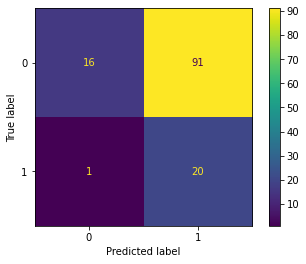

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, ret_test_df['y_hat_test'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

In [37]:
(y_test.sum()/y_test.shape[0]).round(2)

0.16

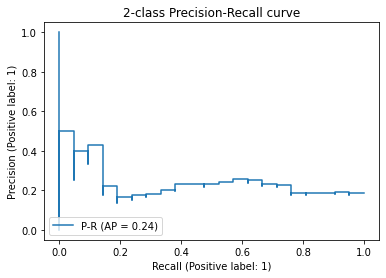

In [38]:
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, name="P-R"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

/tmp/ipykernel_53463/3462016061.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels=ret_test_df.index.strftime('%Y-%m-%d'), rotation=30);


<Figure size 72x72 with 0 Axes>

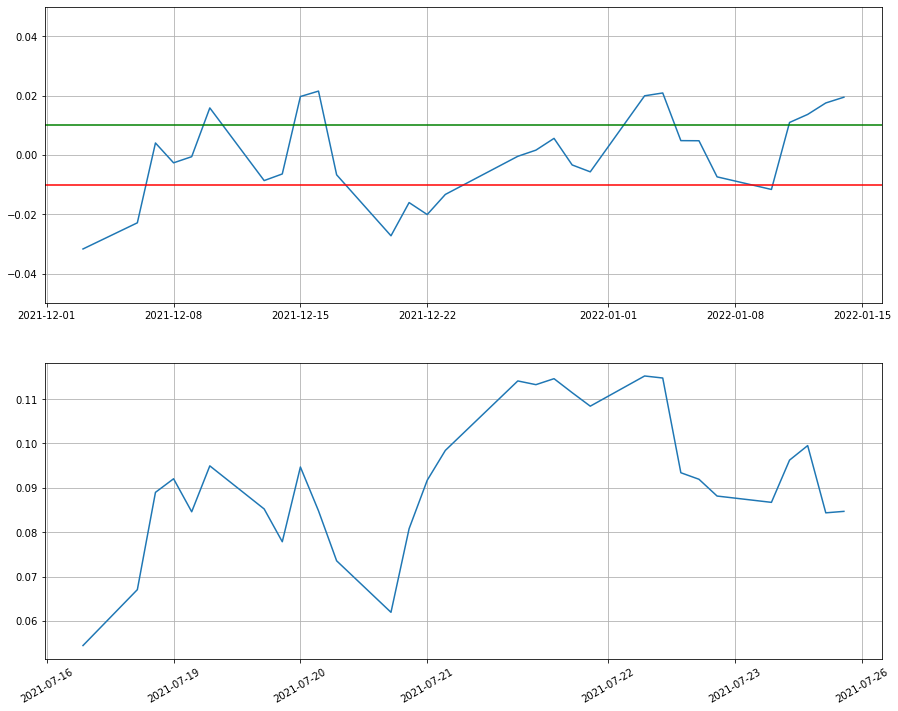

In [41]:

plt.figure(figsize=(1,1))

fig, ax = plt.subplots(2, figsize=(15,12))
#plt.xticks(rotation=45)
#ax[0].set_xticklabels(labels=ret_test_df.index, rotation=30);
ax[0].plot(ret_test_df[['window_change', 'positive_class']][-30:])
ax[0].axhline(y=0.01, color='g', linestyle='-')
ax[0].axhline(y=-0.01, color='r', linestyle='-')
ax[0].set_ylim(top= 0.05)  
ax[0].set_ylim(bottom= -0.05)  # adjust the top leaving bottom unchanged
ax[0].grid()
ax[1].plot(ret_test_df[['norm_returns']][-30:])
ax[1].grid()
ax[1].set_xticklabels(labels=ret_test_df.index.strftime('%Y-%m-%d'), rotation=30);
fig.figsize=(200,300)


<AxesSubplot:xlabel='Date'>

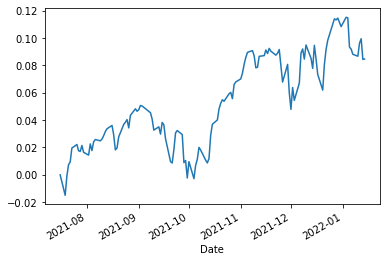

In [42]:
ret_test_df['norm_returns']['2021-06-01':].plot()